Reference video: 
https://www.youtube.com/watch?v=2u1REHeHMrg&list=PL58zEckBH8fBW_XLPtIPlQ-mkSNNx0tLS&index=6

In [1]:
# Import necessary libraries
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl

### Training with Q Table

In [9]:
def cartpole(name, is_training=True, render=False):
    env = gym.make(
        'CartPole-v1', 
        render_mode='human' if render else None
    )
    
    # Divide obversion space into segments
    pos_space = np.linspace(-2.4, 2.4, 10)          # Between -2.4 and 2.4
    vel_space = np.linspace(-4, 4, 10)              # Between -4 and 4
    ang_space = np.linspace(-0.2095, 0.2095, 10)    # Between -0.2095 and 0.2095
    ang_vel_space = np.linspace(-4, 4, 10)          # Between -4 and 4

    # Define Q Table
    if is_training:
        q = np.zeros((
            len(pos_space) + 1, 
            len(vel_space) + 1, 
            len(ang_space) + 1, 
            len(ang_vel_space) + 1,
            env.action_space.n
        ))  # 11x11x11x11x2 Q table
    else:
        f = open(f'q_tables/q_{name}.pkl', 'rb')
        q = pkl.load(f)
        f.close()
    
    # Define the hyperparameters
    learning_rate_a = 0.1   # alpha or learning rate
    discount_factor_g = 0.99 # gamma or discount factor
    
    # Define policy parameters: we use the Epsilon Greedy Algorithm
    epsilon = 1                         # 1 = 100% random actions
    epsilon_decay_rate = 0.00001   # decay rate of epsilon
    rng = np.random.default_rng()       # random number generator
    
    # Keep track of the rewards per episode
    rewards_per_episode = []
    
    # Keep track of the episodes
    i = 0
    
    # Iterate through all episodes
    while (True):
        state = env.reset()[0]  
        state_p = np.digitize(state[0], pos_space)
        state_v = np.digitize(state[1], vel_space)
        state_a = np.digitize(state[2], ang_space)
        state_av = np.digitize(state[3], ang_vel_space)
        terminated = False      # True when the agent falls into a hole or reaches the goal    
        rewards = 0
        
        while(not terminated and rewards < 10000):
            if is_training and rng.random() < epsilon:
                action = env.action_space.sample()  # Actions: 0-left, 1-right,
            else:
                action = np.argmax(q[state_p, state_v, state_a, state_av, :])
            
            new_state, reward, terminated, _, _ = env.step(action)
            new_state_p = np.digitize(new_state[0], pos_space)
            new_state_v = np.digitize(new_state[1], vel_space)
            new_state_a = np.digitize(new_state[2], ang_space)
            new_state_av = np.digitize(new_state[3], ang_vel_space)
            
            # Apply the Q Learning formula after taking a step
            if is_training:
                q[state_p, state_v, state_a, state_av, action] = q[state_p, state_v, state_a, state_av, action] + learning_rate_a * (
                    reward + discount_factor_g * np.max(q[new_state_p, new_state_v, new_state_a, new_state_av, :]) - q[state_p, state_v, state_a, state_av, action]
                )
            
            state = new_state
            state_p = new_state_p
            state_v = new_state_v
            state_a = new_state_a
            state_av = new_state_av
            rewards += reward
            
            if not is_training and rewards%100 == 0:
                print(f'Accumulated rewards: {rewards}')
        
        # Append rewards per episode and calculate mean reward for last 100 episodes
        rewards_per_episode.append(rewards)
        mean_rewards = np.mean(rewards_per_episode[len(rewards_per_episode)-100:])
        
        # Print some information every 100 episodes
        if is_training and i%100 == 0:
            print(f'Episode: {i} {rewards}, Epsilon: {epsilon:0.2f}, Mean Rewards: {mean_rewards:0.1f}')
        
        # Stop training
        if mean_rewards > 1000:
            break
        
        # Decrease epsilon after each episode until it reaches 0
        epsilon = max(epsilon - epsilon_decay_rate, 0)  
        
        # Update i to keep track of the episode number
        i += 1
    
    # Close the environment
    env.close()
    
    # Plot the rewards per episode graph
    if render == False:
        mean_rewards = []
        for t in range(i):
            mean_rewards.append(np.mean(rewards_per_episode[max(0, t-100):(t+1)]))
        plt.xlabel('Iterations')
        plt.ylabel('Mean Rewards')
        plt.plot(mean_rewards)
    
    # Save the Q Table
    if is_training:
        f = open(f'q_tables/q_{name}.pkl', 'wb')
        pkl.dump(q, f)
        f.close()  
        print('Training completed!')

Episode: 0 12.0, Epsilon: 1.00, Mean Rewards: 12.0
Episode: 100 15.0, Epsilon: 1.00, Mean Rewards: 20.4
Episode: 200 20.0, Epsilon: 1.00, Mean Rewards: 19.5
Episode: 300 34.0, Epsilon: 1.00, Mean Rewards: 23.3
Episode: 400 15.0, Epsilon: 1.00, Mean Rewards: 23.0
Episode: 500 40.0, Epsilon: 1.00, Mean Rewards: 19.8
Episode: 600 21.0, Epsilon: 0.99, Mean Rewards: 23.9
Episode: 700 22.0, Epsilon: 0.99, Mean Rewards: 24.4
Episode: 800 13.0, Epsilon: 0.99, Mean Rewards: 21.4
Episode: 900 9.0, Epsilon: 0.99, Mean Rewards: 20.8
Episode: 1000 14.0, Epsilon: 0.99, Mean Rewards: 24.5
Episode: 1100 18.0, Epsilon: 0.99, Mean Rewards: 23.4
Episode: 1200 11.0, Epsilon: 0.99, Mean Rewards: 23.4
Episode: 1300 25.0, Epsilon: 0.99, Mean Rewards: 23.2
Episode: 1400 15.0, Epsilon: 0.99, Mean Rewards: 21.6
Episode: 1500 16.0, Epsilon: 0.99, Mean Rewards: 23.2
Episode: 1600 15.0, Epsilon: 0.98, Mean Rewards: 22.4
Episode: 1700 23.0, Epsilon: 0.98, Mean Rewards: 20.9
Episode: 1800 20.0, Epsilon: 0.98, Mean R

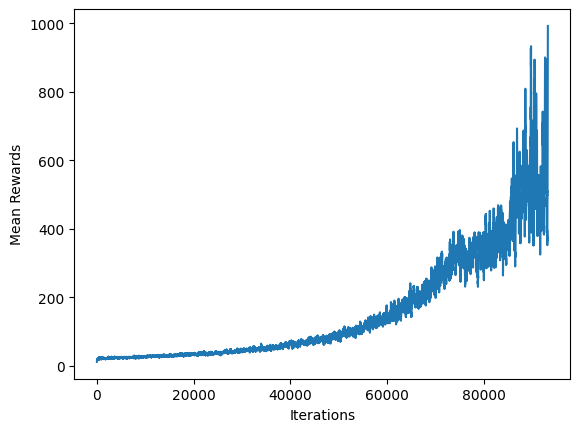

In [10]:
# Train
name = 'cartpole'
cartpole(name)

In [ ]:
# Watch the trained agent
cartpole(name, is_training=False, render=True)